In [1]:
import numpy as np
import tifffile as tf
import json
from pathlib import Path
import matplotlib.pyplot as plt
from time import sleep
from scipy.ndimage import affine_transform

In [7]:
from acpreprocessing.stitching_modules.acstitch.zarrutils import get_group_from_src
from acanalysis.acalignment.utils.kevin_utils import create_mat_json,get_section_label

In [3]:
from skimage.transform import downscale_local_mean
from skimage.io import imsave
def write_array_to_tiff(tiffpath,arr,exclude=None):
    for i in range(arr.shape[0]):
        if not (not exclude is None and i in exclude):
            imsave(tiffpath,arr[i,...],append=True,bigtiff=True)

In [ ]:
# write_array_to_tiff("stack1.tif",section_stacks[1].transpose((2,1,0)))

In [5]:
# Alignment json describing the set of segmented ROI's (SROI's) from each
# section image to be jointly aligned, the image (zarr) data cutout regions
# underlying the segmentation, and file path information to locate
# the zarr datasets and skeletons
align_json = "align_S32_S33_roi2_acdata.json"
with open(align_json) as f:
    alignjs = json.load(f)
mdpath = Path(alignjs["output_path"])

In [8]:
mat_mip = 1
mat_dir = "/ACdata/Users/wanqing/ac_pipeline/ac_align/for_wanqing/materialized/roi2" #"./materialized/roi4"
gap = [260,320] # [260,320]
outpath = Path(mat_dir)
matjspath = outpath / Path("materialize.json")
create_mat_json(matjspath,alignjs,output_path=mat_dir,miplvl=mat_mip,gap_range=gap)
with open(matjspath) as f:
    matjs = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/ACdata/Users/wanqing/ac_pipeline/ac_align/for_wanqing/materialized/roi2/materialize.json'

In [9]:
def mdiv(x,miplvl):
    return int(x/(2**miplvl))

def combine_rois(srcs,cutouts,offsets,miplvl=0,dtype='uint16'):
    tile_dims = [mdiv(cutouts[0][a][1],miplvl)-mdiv(cutouts[0][a][0],miplvl) for a in ["z","y","x"]]
    output_dims = [tile_dims[0],tile_dims[1]+mdiv(offsets[0][1],miplvl),tile_dims[2]]
    print("combining rois from " + str(srcs))
    print("output dimensions: " + str(output_dims))
    A = np.zeros(output_dims,dtype=dtype)
    for i,src in enumerate(srcs):
        tdims = [[mdiv(cutouts[i][a][0],miplvl),mdiv(cutouts[i][a][1],miplvl)] for a in ["z","y","x"]]
        mipdata = get_group_from_src(srcpath=src)[miplvl][0,0,tdims[0][0]:tdims[0][1],tdims[1][0]:tdims[1][1],tdims[2][0]:tdims[2][1]]
        off = [mdiv(o,miplvl) for o in offsets[i]]
        m = mipdata.shape
        A[off[0]:off[0]+m[0],off[1]:off[1]+m[1],off[2]:off[2]+m[2]] = mipdata
    return A

def fix_surface(surfmap,minval=None,maxval=None):
    if not minval is None:
        surfmap[surfmap<minval] = minval
    if not maxval is None:
        surfmap[surfmap>=maxval] = maxval
    return np.round(surfmap.transpose()).astype(int)

def combine_surfaces(surffiles,offsets,miplvl=0,minval=None,maxval=None):
    surfaces = [fix_surface(np.load(f),minval,maxval) for f in surffiles]
    dims = surfaces[0].shape
    output_dims = [dims[0],dims[1]+offsets[0][1]]
    A = np.zeros(output_dims,dtype=int)
    for i,surf in enumerate(surfaces):
        y0 = offsets[i][1]
        m = surf.shape
        A[:,y0:y0+m[1]] = surf
    return downscale_local_mean(A/(2**miplvl),(2**miplvl,2**miplvl)).astype(int)

In [10]:
# VERY IMPORTANT to check transforms if miplvl is not 0 (raw)
# Transforms from alignment are calculated from segmentation coords which should
# ideally be recorded relative to mip level 0...
section_stacks = []
for m,s in zip(matjs["sections"],alignjs["sections"]):
    sdata = combine_rois(srcs=m["sources"],cutouts=s["cutouts"],offsets=s["position_offsets"],miplvl=m["mip_level"])
    section_stacks.append(sdata)

NameError: name 'matjs' is not defined

In [8]:
section_surfaces = []
for s,ss in zip(matjs["sections"],alignjs["sections"]):
    surffiles = [Path(s["align_path"]) / Path(f) for f in s["surface_maps"]]
    surface = combine_surfaces(surffiles=surffiles,offsets=ss["position_offsets"],miplvl=m["mip_level"],minval=0,maxval=576)
    section_surfaces.append(surface)

253

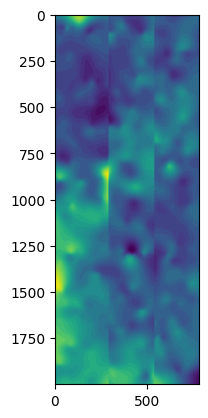

In [9]:
plt.imshow(section_surfaces[1])
np.max(section_surfaces[1])

In [10]:
section_stacks[0].shape

(2000, 780, 288)

In [11]:
M = np.load(Path(matjs["sections"][1]["align_path"]) / Path("model.npy"))
#M = np.load("./roi4_mip1_240408/model.npy")

In [12]:
offset_M = [np.eye(3),np.eye(3)]
offset_M[0][1,2] = -30700
offset_M[1][1,2] = -32000
M_mat = offset_M[0] @ M @ np.linalg.inv(offset_M[1])
print(M_mat)

[[ 9.70665671e-01  2.40433266e-01  5.52110110e+02]
 [-2.40433266e-01  9.70665671e-01 -3.82583056e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [13]:
np.save(outpath / Path("model.npy"),M_mat)

In [14]:
filenames = [get_section_label(s) + "_affine.tif" for s in alignjs["sections"]]
tiffpaths = [outpath / Path(fn) for fn in filenames]
for i,A in enumerate(section_stacks):
    G = section_surfaces[i]
    Bshape = (A.shape[0],A.shape[1],2*A.shape[2])
    if i==0:
        B = np.zeros(Bshape,dtype=A.dtype)
        x0 = A.shape[2]
        xdim = B.shape[2]
        for z in range(A.shape[0]):
            for y in range(A.shape[1]):
                g = G[z,y]
                if g-10<0:
                    B[z,y,x0:] = A[z,y,:]
                else:
                    B[z,y,x0:xdim-(g-10)] = A[z,y,g-10:]
    else:
        B = np.zeros(Bshape,dtype=A.dtype)
        xdim = A.shape[2]
        for z in range(A.shape[0]):
            for y in range(A.shape[1]):
                g = G[z,y]
                if g+10 < xdim:
                    B[z,y,xdim-(g+10):xdim] = A[z,y,:g+10]
                else:
                    B[z,y,:xdim] = A[z,y,:]
    mfile = matjs["sections"][i]["matrix_file"]
    if mfile:
        mpath = outpath / Path(mfile)
        M = np.load(mpath)
        #M = np.load(Path(matjs["sections"][i]["align_path"]) / Path(mfile))
        #M = np.load(Path("J:/Users/kevin/alignment_files/M0_roi2.npy"))
        print("loading transform from " + str(mpath))
        print(M)
        M[:2,2] /= 2**matjs["sections"][i]["mip_level"]
        M2D = np.linalg.inv(M)
        A = B.transpose((2,1,0))
        B = np.zeros(A.shape,dtype=A.dtype)
        for ii in range(A.shape[0]):
            print(ii)
            B[ii] = affine_transform(A[ii],M2D,order=0)#[y.astype(int),x.astype(int)].transpose()
        write_array_to_tiff(tiffpaths[i],B,exclude=range(*matjs["gap_range"]))
    else:
        write_array_to_tiff(tiffpaths[i],B.transpose((2,1,0)),exclude=range(*matjs["gap_range"]))

/tmp/ipykernel_3785470/2823688798.py:6: UserWarning: /ACdata/Users/wanqing/ac_pipeline/ac_align/for_wanqing/roi4_mip1_240408/materialized/roi2/H17_x55_S32_230412_plane2_affine.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)


loading transform from /ACdata/Users/wanqing/ac_pipeline/ac_align/for_wanqing/roi4_mip1_240408/materialized/roi2/model.npy
[[ 9.70665671e-01  2.40433266e-01  5.52110110e+02]
 [-2.40433266e-01  9.70665671e-01 -3.82583056e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
2

/tmp/ipykernel_3785470/2823688798.py:6: UserWarning: /ACdata/Users/wanqing/ac_pipeline/ac_align/for_wanqing/roi4_mip1_240408/materialized/roi2/H17_x55_S33_230413_plane1_affine.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)
